# Stack Exchange Question Quality Detection Classifier

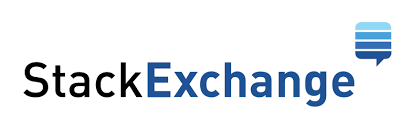

## Aim: Categorise the StackOverflow questions into various quality classes.

### Create a program to label the data into three categories:
1. Good-Quality questions: Questions for which score is greater than 5 and answer count is greater than 0 should be labelled as good quality questions.
2. Low-Quality questions: Questions for which the score is between 0 to 5 and having no answers should be labelled as low-quality questions.
3. Very-low quality questions: Questions which have negative scores

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

### Function to parse XML file and extract relevant features

In [2]:
def parse_XML(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    data = []
    for post in root.findall('row'):
            row = {}
            row['ID'] = int(post.get('Id'))
            row['ViewCount'] = int(post.get('ViewCount')) if post.get('ViewCount') is not None else None
            row['TitleLength'] = len(post.get('Title').split()) if post.get('Title') is not None else None
            row['TextLength'] = len(post.get('Body').split()) if post.get('Body') is not None else None
            row['CommentCount'] = int(post.get('CommentCount')) if post.get('CommentCount') is not None else None
            row['Score'] = int(post.get('Score')) if post.get('Score') is not None else None
            row['AnswerCount'] = int(post.get('AnswerCount')) if post.get('AnswerCount') is not None else None
            if int(post.get('Score')) is not None and row['AnswerCount'] is not None:
                if int(post.get('Score')) > 5 and int(row['AnswerCount']) > 0:
                    row['quality'] = 'good'
                elif 0 <= int(post.get('Score')) <= 5 and int(row['AnswerCount']) == 0:
                    row['quality'] = 'low'
                else:
                    row['quality'] = 'very-low'
            data.append(row)
    return pd.DataFrame(data)

In [3]:
df = parse_XML('/kaggle/input/stack-exchange-questions/Posts.xml')

In [4]:
df.head()

,ID,ViewCount,TitleLength,TextLength,CommentCount,Score,AnswerCount,quality
0,1,13803.0,9.0,41,5,76,5.0,good
1,2,2641.0,9.0,28,4,29,4.0,good
2,3,2412.0,6.0,147,5,35,3.0,good
3,4,NaN,NaN,107,3,22,NaN,NaN
4,5,NaN,NaN,223,0,48,NaN,NaN


In [5]:
Label_counts = df['quality'].value_counts()
print(Label_counts)

very-low    101320
low          22034
good         15356
Name: quality, dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345199 entries, 0 to 345198
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            345199 non-null  int64  
 1   ViewCount     138710 non-null  float64
 2   TitleLength   138710 non-null  float64
 3   TextLength    345199 non-null  int64  
 4   CommentCount  345199 non-null  int64  
 5   Score         345199 non-null  int64  
 6   AnswerCount   138710 non-null  float64
 7   quality       138710 non-null  object 
dtypes: float64(3), int64(4), object(1)
memory usage: 21.1+ MB


In [7]:
df.describe()

,ID,ViewCount,TitleLength,TextLength,CommentCount,Score,AnswerCount
count,345199.000000,138710.000000,138710.000000,345199.000000,345199.000000,345199.000000,138710.000000
mean,238794.281768,1320.033566,9.007736,170.900182,1.956263,2.723235,1.478920
std,142377.068645,6404.536977,4.327148,171.572892,2.831285,7.567259,1.307238
min,1.000000,3.000000,1.000000,0.000000,0.000000,-24.000000,0.000000
25%,112587.500000,83.000000,6.000000,70.000000,0.000000,0.000000,1.000000
50%,238558.000000,217.000000,8.000000,123.000000,1.000000,1.000000,1.000000
75%,362380.000000,716.000000,11.000000,213.000000,3.000000,3.000000,2.000000
max,483787.000000,785052.000000,33.000000,5135.000000,114.000000,726.000000,49.000000


### Removing none type values in dataframe

In [8]:
df1 = df.dropna()

In [9]:
df2 = df1.drop('ID', axis=1)

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138710 entries, 0 to 345198
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ViewCount     138710 non-null  float64
 1   TitleLength   138710 non-null  float64
 2   TextLength    138710 non-null  int64  
 3   CommentCount  138710 non-null  int64  
 4   Score         138710 non-null  int64  
 5   AnswerCount   138710 non-null  float64
 6   quality       138710 non-null  object 
dtypes: float64(3), int64(3), object(1)
memory usage: 8.5+ MB


## EDA

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

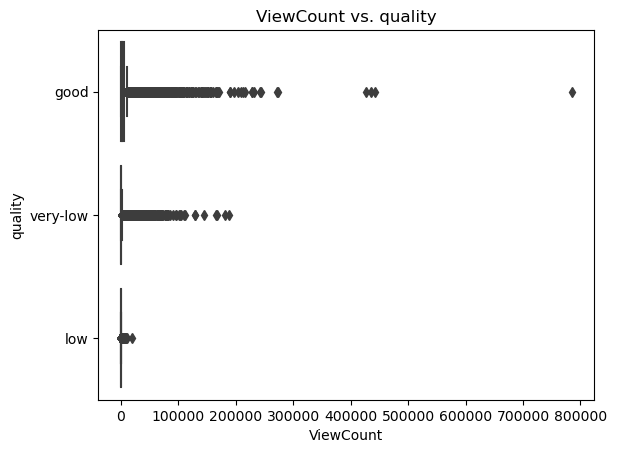

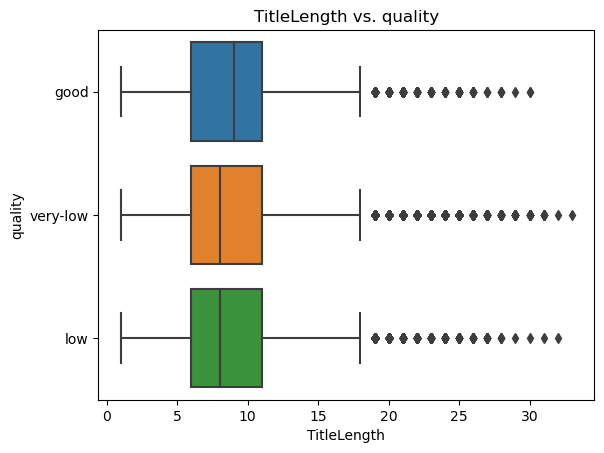

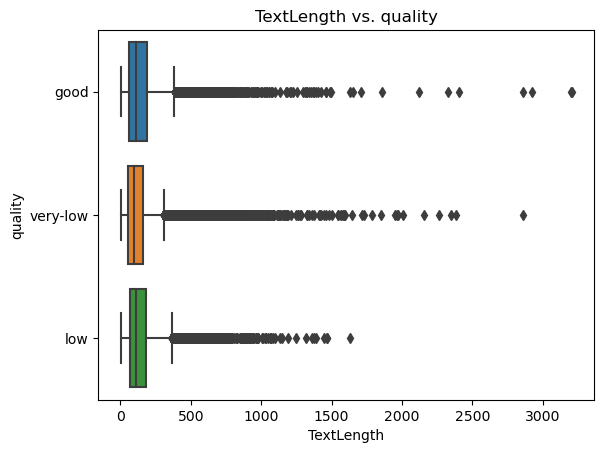

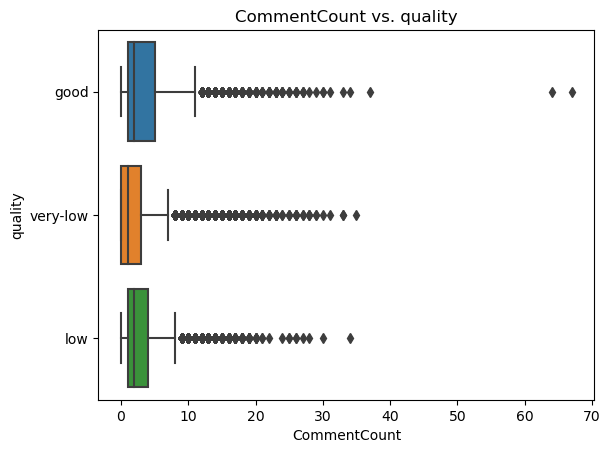

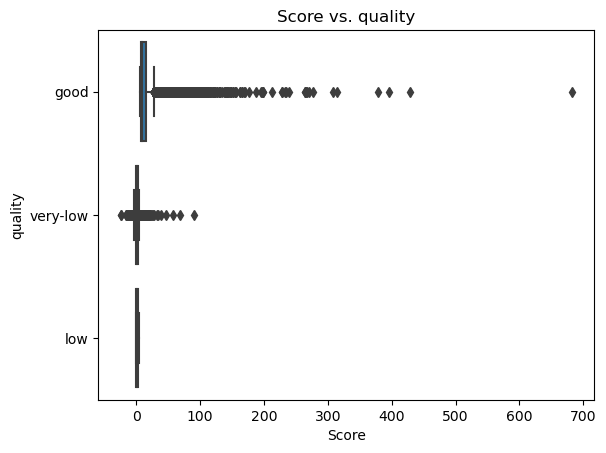

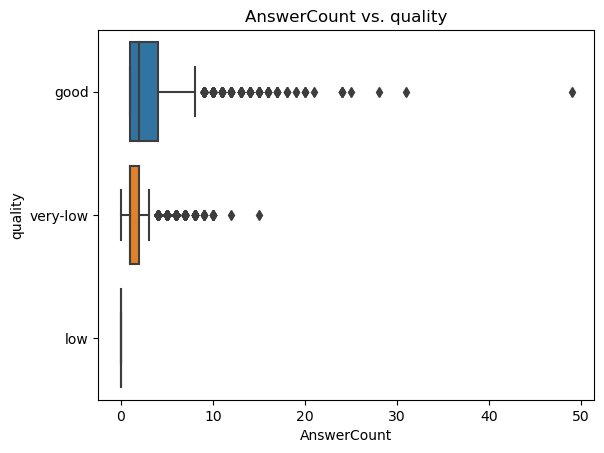

In [12]:
features = ['ViewCount', 'TitleLength', 'TextLength', 'CommentCount','Score','AnswerCount']
target = 'quality'
for feature in features:
    fig, ax = plt.subplots()
    sns.boxplot(x=feature, y=target, data=df2, ax=ax)
    ax.set_title(f'{feature} vs. {target}')

#### From above graphs, we seen that each feature has outliers. Removing these outliers will often help our model to generalize better as these long tail observations could skew the learning.


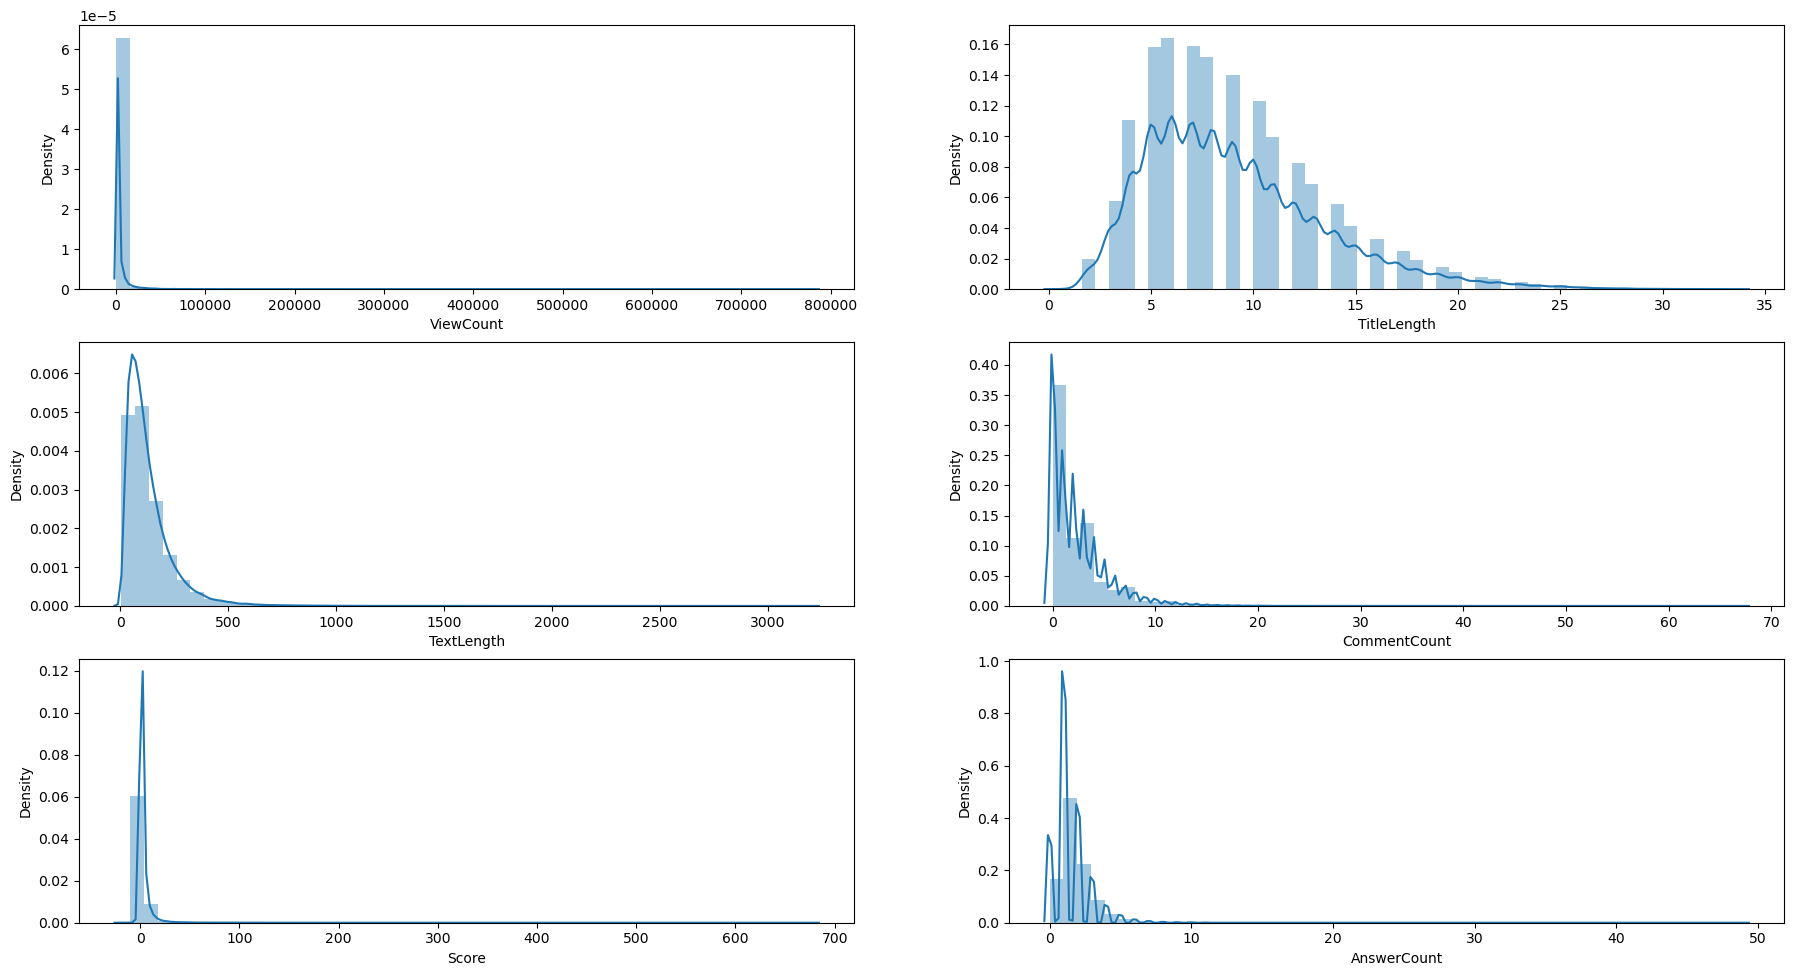

In [13]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(22,24))
plt.subplot(6,2,1)
sns.distplot(df2['ViewCount'])
plt.subplot(6,2,2)
sns.distplot(df2['TitleLength'])
plt.subplot(6,2,3)
sns.distplot(df2['TextLength'])
plt.subplot(6,2,4)
sns.distplot(df2['CommentCount'])
plt.subplot(6,2,5)
sns.distplot(df2['Score'])
plt.subplot(6,2,6)
sns.distplot(df2['AnswerCount'])
plt.show()

#### The distribution plots shows each feature graph is right (positive) skewed.we can apply Z-Score on the normally distributed columns while IQR is on either left or right-skewed data.
#### we will use IQR (Inter Quartile Range) to remove outliers.

In [14]:
# Calculate the IQR for each column
Q1 = df2.quantile(0.25)
Q3 = df2.quantile(0.75)
IQR = Q3 - Q1

# Remove outliers
df3 = df2[~((df2 < (Q1 - 1.5 * IQR)) | (df2 > (Q3 + 1.5 * IQR))).any(axis=1)]

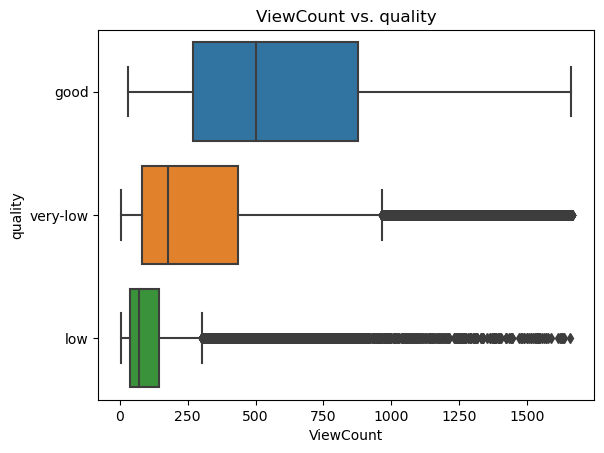

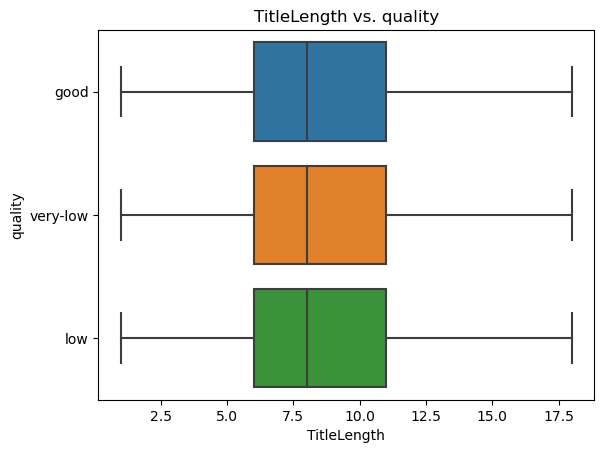

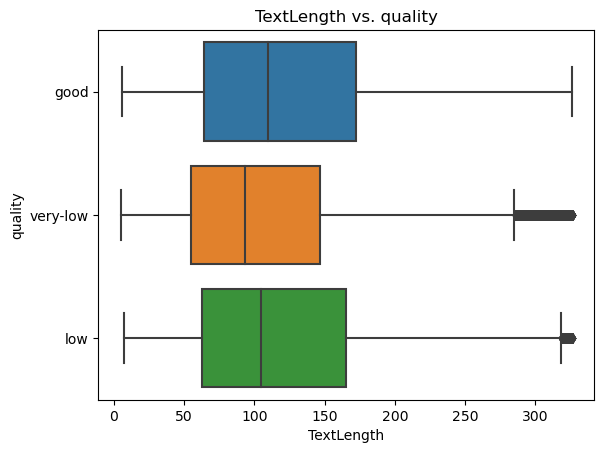

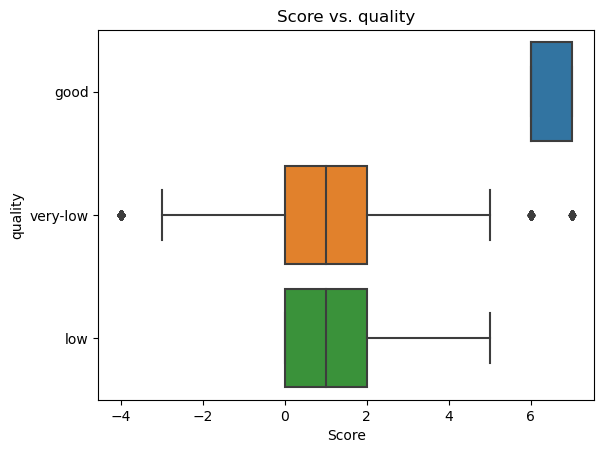

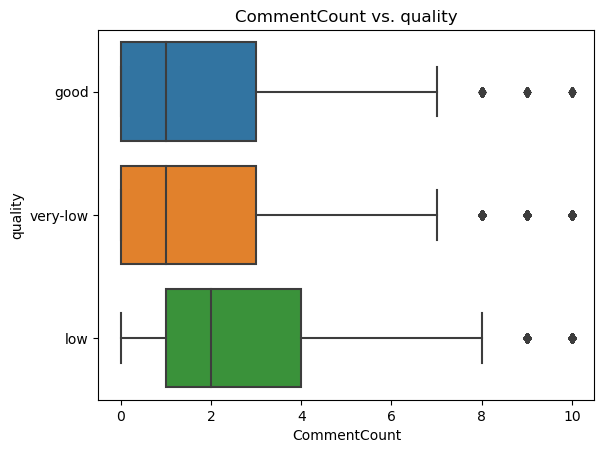

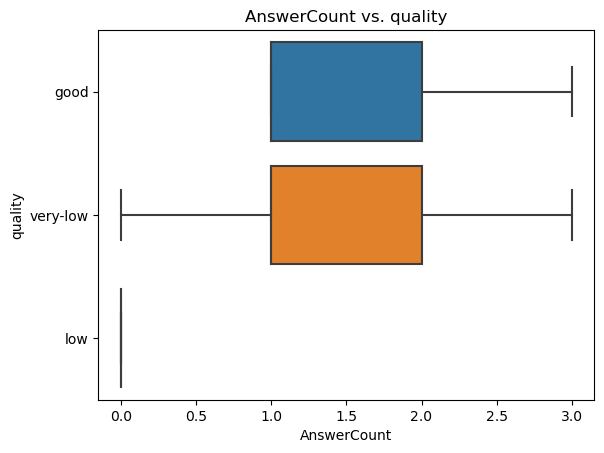

In [15]:
features = ['ViewCount', 'TitleLength', 'TextLength','Score','CommentCount','AnswerCount']
target = 'quality'
for feature in features:
    fig, ax = plt.subplots()
    sns.boxplot(x=feature, y=target, data=df3, ax=ax)
    ax.set_title(f'{feature} vs. {target}')

#### As we removed outliers for title length, text length, comment count, but we cant able to remove outliers properly in view counts for low quality questions class. let we see the importance of view count feature using heatmap correlation.

<AxesSubplot:>

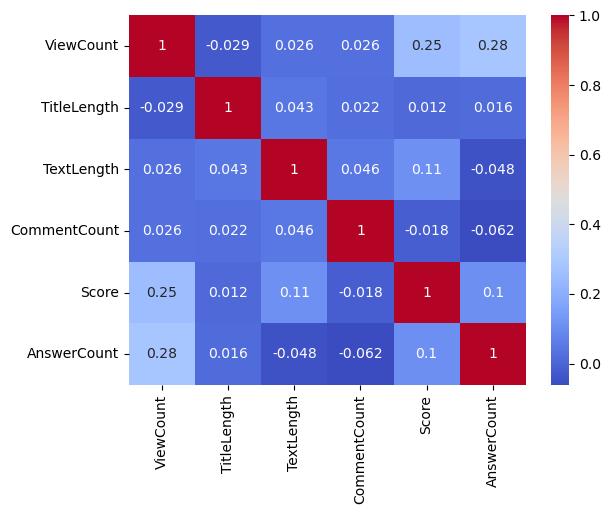

In [16]:
corr = df3.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

#### The heatmap shows, the viewcount has higher importance in dataset with answercount. we will use viewcount feature with outliers has it has valauble information in predicting the output.

In [17]:
qua_counts = df3['quality'].value_counts()
print(qua_counts)

very-low    79341
low         19366
good         2867
Name: quality, dtype: int64


In [18]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101574 entries, 33 to 345198
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ViewCount     101574 non-null  float64
 1   TitleLength   101574 non-null  float64
 2   TextLength    101574 non-null  int64  
 3   CommentCount  101574 non-null  int64  
 4   Score         101574 non-null  int64  
 5   AnswerCount   101574 non-null  float64
 6   quality       101574 non-null  object 
dtypes: float64(3), int64(3), object(1)
memory usage: 10.2+ MB


#### The above count shows an imbalanced dataset. we need to balance each class to train the model. before that we need to split the dataset to test and train and sample the train dataset. if we done sampling before the test_train_split , data leakage will happen and it will not give present real dataset to model while testing the model. 

### splitting the dataset to test and train.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df3[['ViewCount', 'TitleLength', 'TextLength', 'CommentCount','Score','AnswerCount']], df3['quality'], test_size=0.2, random_state=42)

#### sampling the train dataset to give balanced dataset to model.

In [20]:
y_train.value_counts()

very-low    63367
low         15586
good         2306
Name: quality, dtype: int64

#### feature scaling can improve the performance of machine learning algorithms by ensuring that all features contribute equally to the model's predictions.

In [21]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### we are using random undersampler to balance the dataset.

In [22]:
from imblearn.under_sampling import RandomUnderSampler

# Define the resampling strategy for each class
sampling_strategy = {'very-low': 2306, 'low': 2306, 'good': 2306}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

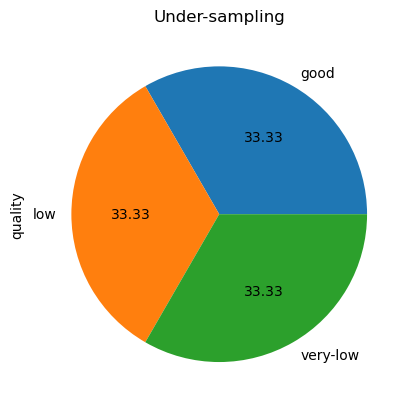

In [23]:
ap = y_resampled.value_counts().plot.pie(autopct='%.2f')
_ = ap.set_title("Under-sampling")

### Training the models

### Logistic regression

In [24]:
lr_model = LogisticRegression()
lr_model.fit(X_resampled, y_resampled)
y_pred_lr = lr_model.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)
print('Logistic Regression accuracy:', acc_lr)
print()
cm_lr = confusion_matrix(y_test, y_pred_lr)
print('Confusion Matrix (Logistic Regression):\n', cm_lr)
print()
print('Classification Report (Logistic Regression):\n',classification_report(y_test,y_pred_lr))
probs_lr = lr_model.predict_proba(X_test)

Logistic Regression accuracy: 0.9970957420625154

Confusion Matrix (Logistic Regression):
 [[  561     0     0]
 [    0  3780     0]
 [   13    46 15915]]

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

        good       0.98      1.00      0.99       561
         low       0.99      1.00      0.99      3780
    very-low       1.00      1.00      1.00     15974

    accuracy                           1.00     20315
   macro avg       0.99      1.00      0.99     20315
weighted avg       1.00      1.00      1.00     20315



#### The results indicate that the logistic regression model has a high accuracy of 0.996. The confusion matrix shows that the model correctly classified 868 good quality questions, 1939 low-quality questions, and 9537 very-low quality questions. The classification report shows that the precision, recall, and F1-score for each class is also high. The weighted average F1-score is also 1.0, indicating that the model performs very well for all classes. Overall, the logistic regression model seems to be performing very well for this multiclass classification task.

In [25]:
# Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
nb_model.fit(X_resampled, y_resampled)
y_pred_nb = nb_model.predict(X_test)
acc_nb = accuracy_score(y_test, y_pred_nb)
print('Multinomial Naive Bayes accuracy:', acc_nb)
print()
cm_nb = confusion_matrix(y_test, y_pred_nb)
print('Confusion Matrix (Multinomial Naive Bayes):\n', cm_nb)
print()
print('Classification Report (Multinomial Naive Bayes):\n',classification_report(y_test,y_pred_nb))
probs_nb = nb_model.predict_proba(X_test)

Multinomial Naive Bayes accuracy: 0.9839035195668225

Confusion Matrix (Multinomial Naive Bayes):
 [[  561     0     0]
 [    1  3766    13]
 [  267    46 15661]]

Classification Report (Multinomial Naive Bayes):
               precision    recall  f1-score   support

        good       0.68      1.00      0.81       561
         low       0.99      1.00      0.99      3780
    very-low       1.00      0.98      0.99     15974

    accuracy                           0.98     20315
   macro avg       0.89      0.99      0.93     20315
weighted avg       0.99      0.98      0.99     20315



####  The Multinomial Naive Bayes model has an accuracy of 0.957, which is relatively high. The confusion matrix also shows that the model predicted class 0 (the first column) for 1,357 samples, class 1 (the second column) for 1,914 samples, and class 2 (the third column) for 8,328 samples.
#### Overall, the model seems to have performed well, with a high accuracy and relatively low number of false positives and false negatives.

In [26]:
# Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_resampled, y_resampled)
y_pred_rf = rf_model.predict(X_test)
acc_tr_rf = rf_model.score(X_resampled, y_resampled)
acc_rf = accuracy_score(y_test, y_pred_rf)
print('Training dataset Random Forest accuracy:', acc_tr_rf)
print()
print('Random Forest accuracy:', acc_rf)
print()
cm_rf = confusion_matrix(y_test, y_pred_rf)
print('Confusion Matrix (Random Forest):\n', cm_rf)
print()
print('Classification Report (Random Forest):\n',classification_report(y_test,y_pred_rf))
probs_rfc = rf_model.predict_proba(X_test)

Training dataset Random Forest accuracy: 1.0

Random Forest accuracy: 0.9989170563622939

Confusion Matrix (Random Forest):
 [[  561     0     0]
 [    0  3780     0]
 [    0    22 15952]]

Classification Report (Random Forest):
               precision    recall  f1-score   support

        good       1.00      1.00      1.00       561
         low       0.99      1.00      1.00      3780
    very-low       1.00      1.00      1.00     15974

    accuracy                           1.00     20315
   macro avg       1.00      1.00      1.00     20315
weighted avg       1.00      1.00      1.00     20315



#### The Random Forest model has an accuracy of 0.999, which is very high. The confusion matrix also shows that the model predicted class 0 (the first column) for 868 samples, class 1 (the second column) for 1,939 samples, and class 2 (the third column) for 9,582 samples. Overall, the model seems to have performed very well, with a very high accuracy and very low number of false positives and false negatives.

### Conclusions
* We can take Random Forest model for classification, it performs very well compare to other models.
* we removed outliers and undersampled the dataset to train the model perfectly. these techniques improved the model performance and accuracy score is very high. 
* we almost used all available features given in dataset and we also consumed total data given. 
* The standard featuring scaling improved the performance of logistic regression, though feature scaling is not needed for random forest classifier.
